In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

In [2]:
pwd

'C:\\Users\\635718\\Desktop\\DataScience\\HackerEarth\\MLC4'

In [3]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [4]:
id_test = test['connection_id'].values

In [5]:
train.shape

(169307, 43)

In [6]:
train.head(2)

,connection_id,cont_1,cont_2,cont_3,cont_4,cont_5,cont_6,cont_7,cont_8,cont_9,...,cat_15,cat_16,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,target
0,cxcon_1,0,1032,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,2
1,cxcon_4,0,520,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,511,511,255,255,0


In [7]:
train['target'].value_counts()

0    98868
2    36854
1    33585
Name: target, dtype: int64

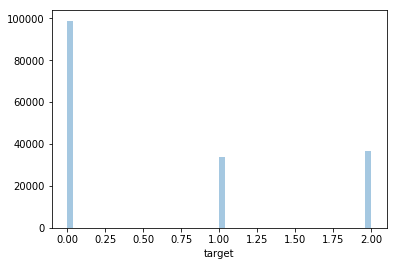

In [8]:
sns.distplot(train['target'], kde=False)

In [9]:
test.shape

(91166, 42)

In [ ]:
train_features = [x for x in train.columns if x not in ['connection_id','target']]

X = train[train_features].values
y = train.loc[:,'target'].values
T = test[train_features].values

#create the models
# LightGBM params
lgb_params_1 = {
    'learning_rate': 0.01,
    'n_estimators': 1250,
    'max_bin': 10,
    'subsample': 0.8,
    'subsample_freq': 10,
    'colsample_bytree': 0.8, 
    'min_child_samples': 500
}

lgb_params_2 = {
    'learning_rate': 0.005,
    'n_estimators': 3700,
    'subsample': 0.7,
    'subsample_freq': 2,
    'colsample_bytree': 0.3,  
    'num_leaves': 16
}

lgb_params_3 = {
   'objective':'binary:logistic',
   'learning_rate':0.02,
    'n_estimators':1000,
    'max_depth':4,
    'subsample':0.9,
    'colsample_bytree':0.9,  
    'min_child_weight':10
}

lgb_model_1 = LGBMClassifier(**lgb_params_1)
lgb_model_2 = LGBMClassifier(**lgb_params_2)
lgb_model_3 = XGBClassifier(**lgb_params_3)
#base_models = (lgb_model_1, lgb_model_2, lgb_model_3)
base_models = (lgb_model_1, lgb_model_2)

log_model = LogisticRegression()
stacker = log_model
print("models created")

In [60]:
train_features = [x for x in train.columns if x not in ['connection_id','target']]

X = train[train_features].values
y = train.loc[:,'target'].values
T = test[train_features].values

clf1 = RandomForestClassifier()
clf2 = RandomForestClassifier()

base_models = (clf1, clf2)

log_model = LogisticRegression()
stacker = log_model
print("models created")

models created


(112871, 41)
Fit RandomForestClassifier fold 1
(112871, 41)
Fit RandomForestClassifier fold 2
(112872, 41)
Fit RandomForestClassifier fold 3
(112871, 41)
Fit RandomForestClassifier fold 1
(112871, 41)
Fit RandomForestClassifier fold 2
(112872, 41)
Fit RandomForestClassifier fold 3


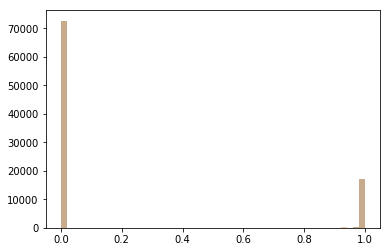

In [69]:
#now we have the data with equal set of positives and negatives
#lets check cross validation scores
from scipy.stats import mode
n_splits=3
folds = list(StratifiedKFold(n_splits, shuffle=True, random_state=10).split(X, y))
S_train = np.zeros((X.shape[0], len(base_models)))
S_test = np.zeros((T.shape[0], len(base_models)))

for i, clf in enumerate(base_models):
    S_test_i = np.zeros((T.shape[0], n_splits))
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        print(X_train.shape)
        
        """# Get positive examples
        pos_1 = pd.Series(y_train == 1)
        pos_2 = pd.Series(y_train == 2)
        # Add positive examples - 1
        X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train[pos_1])])
        y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train[pos_1])])
        # Add positive examples - 2
        X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train[pos_2])])
        y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train[pos_2])])
        
        # Shuffle data
        idx = np.arange(len(X_train))
        np.random.shuffle(idx)
        X_train = X_train.iloc[idx]
        y_train = y_train.iloc[idx]"""

        print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
        clf.fit(X_train, y_train)
        #y_pred = clf.predict(X_holdout)
        y_pred = clf.predict_proba(X_holdout)[:,1]  
        
        S_train[test_idx, i] = y_pred
        #S_test_i[:, j] = clf.predict(T)
        S_test_i[:, j] = clf.predict_proba(T)[:,1]
    
    #print(S_test_i)
    #print(mode(S_test_i, axis=1)[0].flatten())
    #print(S_test_i.mean(axis=1))
    #S_test[:, i] = mode(S_test_i, axis=1)[0].flatten()
    S_test[:, i] = S_test_i.mean(axis=1)
    sns.distplot(S_test[:, i],kde=False)

In [61]:
results = cross_val_score(stacker, X, y, cv=5)
print("Stacker score: %.5f" % (results.mean()))
print(results)

print("S train size is : ", S_train.shape)
stacker.fit(X, y)
res = stacker.predict(T)

print(res)

Stacker score: 0.77322
[ 0.7737582   0.7748804   0.7713366   0.7717433   0.77436503]
S train size is :  (169307, 2)
[1 0 0 ..., 0 0 1]


In [29]:
print(len(res))
print(len(id_test))

91166
91166


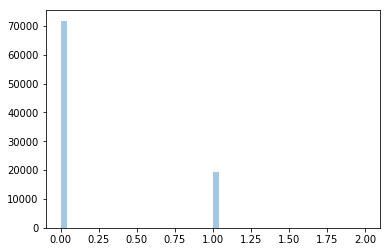

In [62]:
sns.distplot(res,kde=False)

In [ ]:
print(results)
print(res)

sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = res
sub.to_csv('stacked_result_strat_upsample.csv', index=False)

print('completed')